# Session 3: Measuring Abnormal Returns

## Event Studies in Finance and Economics - Summer School

---

### Learning Objectives

By the end of this session, you will be able to:

1. Calculate and interpret different measures of abnormal returns (AR, CAR, BHAR)
2. Understand the trade-offs between CAR and BHAR approaches
3. Compute standardized abnormal returns for improved inference
4. Translate abnormal returns into economic magnitudes (wealth effects)
5. Handle multiple events and aggregate abnormal returns across firms

---

## 1. Introduction: From Normal to Abnormal

In Sessions 1 and 2, we established how to estimate "normal" returns. Now we focus on measuring and interpreting the **abnormal** component — the return attributable to the event.

### The Fundamental Equation

$$AR_{i,t} = R_{i,t} - E[R_{i,t} | X_t]$$

Where:
- $AR_{i,t}$ = Abnormal return for firm $i$ on day $t$
- $R_{i,t}$ = Actual (realized) return
- $E[R_{i,t} | X_t]$ = Expected (normal) return from our benchmark model

### Why Measurement Matters

The choice of how we aggregate abnormal returns over time affects:
1. **Statistical properties** of our test statistics
2. **Economic interpretation** of the results
3. **Comparability** across studies
4. **Bias** in long-horizon studies

## 2. Setup and Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import yfinance as yf
import statsmodels.api as sm
from datetime import datetime, timedelta
from typing import List, Dict, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [2]:
# We'll use multiple events to demonstrate aggregation
EVENTS = [
    {'ticker': 'AAPL', 'date': '2023-08-03', 'name': 'Apple Q3 Earnings'},
    {'ticker': 'MSFT', 'date': '2023-07-25', 'name': 'Microsoft Q4 Earnings'},
    {'ticker': 'GOOGL', 'date': '2023-07-25', 'name': 'Alphabet Q2 Earnings'},
    {'ticker': 'AMZN', 'date': '2023-08-03', 'name': 'Amazon Q2 Earnings'},
    {'ticker': 'META', 'date': '2023-07-26', 'name': 'Meta Q2 Earnings'},
]

ESTIMATION_WINDOW = 120
GAP = 10
EVENT_WINDOW_PRE = 10
EVENT_WINDOW_POST = 10

print(f"Analyzing {len(EVENTS)} earnings announcements")
for e in EVENTS:
    print(f"  {e['ticker']}: {e['name']} ({e['date']})")

Analyzing 5 earnings announcements
  AAPL: Apple Q3 Earnings (2023-08-03)
  MSFT: Microsoft Q4 Earnings (2023-07-25)
  GOOGL: Alphabet Q2 Earnings (2023-07-25)
  AMZN: Amazon Q2 Earnings (2023-08-03)
  META: Meta Q2 Earnings (2023-07-26)


In [5]:
def download_event_data(ticker: str, event_date: str, est_window: int, 
                        gap: int, pre: int, post: int) -> Tuple[pd.DataFrame, pd.Timestamp]:
    """
    Download and prepare data for a single event.
    
    Returns:
    --------
    DataFrame with returns and event time, actual event date
    """
    event_dt = pd.to_datetime(event_date)
    start_date = event_dt - timedelta(days=int((est_window + gap + pre) * 1.5))
    end_date = event_dt + timedelta(days=int(post * 2.5))
    
    stock = yf.download(ticker, start=start_date, end=end_date, progress=False)['Close']
    market = yf.download('^GSPC', start=start_date, end=end_date, progress=False)['Close']
    
    df = pd.DataFrame({
        'stock_price': stock.squeeze(),
        'market_price': market.squeeze()
    })
    
    df['stock_ret'] = df['stock_price'].pct_change()
    df['market_ret'] = df['market_price'].pct_change()
    df = df.dropna()
    
    # Adjust event date if not a trading day
    if event_dt not in df.index:
        idx = df.index.get_indexer([event_dt], method='nearest')[0]
        event_dt = df.index[idx]
    
    event_idx = df.index.get_loc(event_dt)
    df['event_time'] = range(-event_idx, len(df) - event_idx)
    
    return df, event_dt


def estimate_market_model(est_data: pd.DataFrame) -> Dict:
    """
    Estimate market model parameters.
    """
    y = est_data['stock_ret'].values
    x = est_data['market_ret'].values
    X = sm.add_constant(x)
    results = sm.OLS(y, X).fit()
    
    return {
        'alpha': results.params[0],
        'beta': results.params[1],
        'sigma': np.std(results.resid, ddof=2),
        'r_squared': results.rsquared,
        'n_obs': len(y),
        'market_mean': np.mean(x),
        'market_var': np.sum((x - np.mean(x))**2)
    }


def process_single_event(event: Dict, est_window: int, gap: int, 
                         pre: int, post: int) -> Dict:
    """
    Process a single event: download data, estimate model, calculate ARs.
    """
    data, actual_date = download_event_data(
        event['ticker'], event['date'], est_window, gap, pre, post
    )
    
    # Split windows
    est_end = -(gap + pre)
    est_start = est_end - est_window
    
    est_data = data[(data['event_time'] >= est_start) & (data['event_time'] < est_end)]
    evt_data = data[(data['event_time'] >= -pre) & (data['event_time'] <= post)].copy()
    
    # Estimate model
    model = estimate_market_model(est_data)
    
    # Calculate expected and abnormal returns
    evt_data['expected_ret'] = model['alpha'] + model['beta'] * evt_data['market_ret']
    evt_data['AR'] = evt_data['stock_ret'] - evt_data['expected_ret']
    
    return {
        'ticker': event['ticker'],
        'name': event['name'],
        'event_date': actual_date,
        'model': model,
        'event_data': evt_data,
        'estimation_data': est_data
    }


# Process all events
print("Processing events...")
event_results = []
for event in EVENTS:
    try:
        result = process_single_event(event, ESTIMATION_WINDOW, GAP, 
                                       EVENT_WINDOW_PRE, EVENT_WINDOW_POST)
        event_results.append(result)
        print(f"  {event['ticker']}: OK (beta={result['model']['beta']:.3f})")
    except Exception as e:
        print(f"  {event['ticker']}: FAILED - {e}")

print(f"\nSuccessfully processed {len(event_results)} events")

Processing events...
YF.download() has changed argument auto_adjust default to True
  AAPL: OK (beta=1.127)
  MSFT: OK (beta=1.249)
  GOOGL: OK (beta=1.404)
  AMZN: OK (beta=1.521)
  META: OK (beta=1.891)

Successfully processed 5 events


## 3. Daily Abnormal Returns (AR)

### Definition

The daily abnormal return is simply the difference between actual and expected return:

$$AR_{i,t} = R_{i,t} - (\hat{\alpha}_i + \hat{\beta}_i R_{m,t})$$

### Properties

Under the null hypothesis of no event effect:
- $E[AR_{i,t}] = 0$
- $Var(AR_{i,t}) = \sigma^2_{\epsilon_i} \left[ 1 + \frac{1}{T} + \frac{(R_{m,t} - \bar{R}_m)^2}{\sum(R_{m,t} - \bar{R}_m)^2} \right]$

The variance includes:
1. Residual variance from the market model
2. Estimation error in alpha
3. Estimation error in beta (larger when market return is extreme)

In [7]:
def calculate_ar_variance(model: Dict, market_returns: np.ndarray) -> np.ndarray:
    """
    Calculate the variance of abnormal returns accounting for estimation error.
    
    Var(AR) = sigma^2 * [1 + 1/T + (Rm - Rm_bar)^2 / sum((Rm - Rm_bar)^2)]
    """
    sigma_sq = model['sigma'] ** 2
    T = model['n_obs']
    Rm_bar = model['market_mean']
    sum_sq = model['market_var']
    
    variance = sigma_sq * (
        1 + 
        1/T + 
        (market_returns - Rm_bar)**2 / sum_sq
    )
    
    return variance


# Display AR for first event
example = event_results[0]
evt_data = example['event_data'].copy()

# Add variance and standard error
evt_data['AR_var'] = calculate_ar_variance(example['model'], evt_data['market_ret'].values)
evt_data['AR_se'] = np.sqrt(evt_data['AR_var'])

print(f"Daily Abnormal Returns: {example['ticker']} ({example['name']})")
print("="*80)

display_df = evt_data[['event_time', 'stock_ret', 'market_ret', 'expected_ret', 'AR', 'AR_se']].copy()
display_df.index = evt_data.index.strftime('%Y-%m-%d')
for col in ['stock_ret', 'market_ret', 'expected_ret', 'AR', 'AR_se']:
    display_df[col] = display_df[col].apply(lambda x: f"{x*100:.2f}%")

print(display_df.to_string())

Daily Abnormal Returns: AAPL (Apple Q3 Earnings)
            event_time stock_ret market_ret expected_ret      AR  AR_se
Date                                                                   
2023-07-20         -10    -1.01%     -0.68%       -0.56%  -0.45%  0.81%
2023-07-21          -9    -0.62%      0.03%        0.24%  -0.86%  0.81%
2023-07-24          -8     0.42%      0.40%        0.66%  -0.24%  0.81%
2023-07-25          -7     0.45%      0.28%        0.52%  -0.07%  0.81%
2023-07-26          -6     0.45%     -0.02%        0.19%   0.27%  0.81%
2023-07-27          -5    -0.66%     -0.64%       -0.52%  -0.14%  0.81%
2023-07-28          -4     1.35%      0.99%        1.32%   0.03%  0.81%
2023-07-31          -3     0.32%      0.15%        0.37%  -0.05%  0.81%
2023-08-01          -2    -0.43%     -0.27%       -0.09%  -0.33%  0.81%
2023-08-02          -1    -1.55%     -1.38%       -1.35%  -0.20%  0.82%
2023-08-03           0    -0.73%     -0.25%       -0.08%  -0.65%  0.81%
2023-08-04     

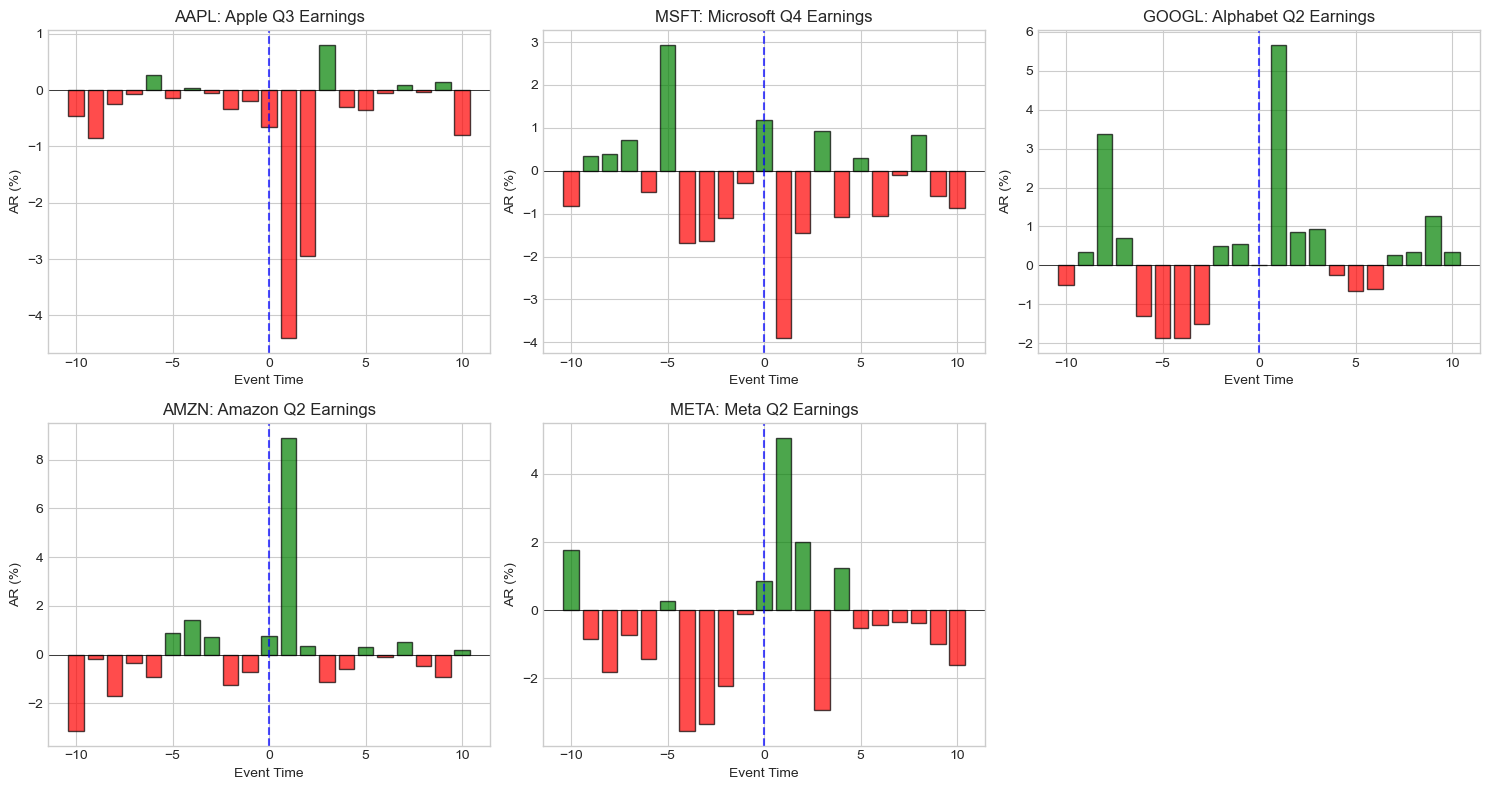

In [9]:
# Visualize daily ARs for all events
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, result in enumerate(event_results):
    if i >= 5:
        break
    ax = axes[i]
    evt = result['event_data']
    
    colors = ['green' if ar >= 0 else 'red' for ar in evt['AR']]
    ax.bar(evt['event_time'], evt['AR']*100, color=colors, alpha=0.7, edgecolor='black')
    ax.axhline(0, color='black', linewidth=0.5)
    ax.axvline(0, color='blue', linestyle='--', alpha=0.7, label='Event Day')
    
    ax.set_xlabel('Event Time')
    ax.set_ylabel('AR (%)')
    ax.set_title(f"{result['ticker']}: {result['name']}")
    ax.set_xticks(range(-EVENT_WINDOW_PRE, EVENT_WINDOW_POST+1, 5))

# Hide empty subplot
axes[5].axis('off')

plt.tight_layout()
plt.show()

## 4. Cumulative Abnormal Returns (CAR)

### Definition

The CAR sums daily abnormal returns over an event window:

$$CAR_i(\tau_1, \tau_2) = \sum_{t=\tau_1}^{\tau_2} AR_{i,t}$$

### Common Windows

| Window | Interpretation |
|--------|----------------|
| CAR(0, 0) | Event day only |
| CAR(-1, +1) | Three-day window (captures leakage and delayed reaction) |
| CAR(-5, +5) | Eleven-day window |
| CAR(0, +T) | Post-event drift |
| CAR(-T, -1) | Pre-event anticipation |

### Variance of CAR

Assuming independence across days:

$$Var(CAR_i(\tau_1, \tau_2)) = \sum_{t=\tau_1}^{\tau_2} Var(AR_{i,t})$$

For the simplified case (ignoring estimation error):

$$Var(CAR_i(\tau_1, \tau_2)) \approx (\tau_2 - \tau_1 + 1) \cdot \sigma^2_{\epsilon_i}$$

In [12]:
def calculate_car(event_data: pd.DataFrame, tau1: int, tau2: int) -> float:
    """
    Calculate Cumulative Abnormal Return for a window.
    
    Parameters:
    -----------
    event_data : DataFrame with 'event_time' and 'AR' columns
    tau1, tau2 : Start and end of window (inclusive)
    
    Returns:
    --------
    CAR value
    """
    mask = (event_data['event_time'] >= tau1) & (event_data['event_time'] <= tau2)
    return event_data.loc[mask, 'AR'].sum()


def calculate_car_variance(model: Dict, event_data: pd.DataFrame, 
                           tau1: int, tau2: int) -> float:
    """
    Calculate variance of CAR accounting for estimation error.
    """
    mask = (event_data['event_time'] >= tau1) & (event_data['event_time'] <= tau2)
    window_data = event_data[mask]
    
    ar_variances = calculate_ar_variance(model, window_data['market_ret'].values)
    return np.sum(ar_variances)


def calculate_all_cars(result: Dict, windows: List[Tuple[int, int]]) -> pd.DataFrame:
    """
    Calculate CARs for multiple windows.
    """
    cars = []
    for tau1, tau2 in windows:
        car = calculate_car(result['event_data'], tau1, tau2)
        car_var = calculate_car_variance(result['model'], result['event_data'], tau1, tau2)
        car_se = np.sqrt(car_var)
        t_stat = car / car_se if car_se > 0 else 0
        
        cars.append({
            'Window': f'[{tau1:+d}, {tau2:+d}]',
            'CAR': car,
            'SE': car_se,
            't-stat': t_stat,
            'p-value': 2 * (1 - stats.t.cdf(abs(t_stat), df=result['model']['n_obs']-2))
        })
    
    return pd.DataFrame(cars)


# Calculate CARs for standard windows
standard_windows = [
    (-10, -2),   # Pre-event
    (-1, +1),    # Standard 3-day
    (0, 0),      # Event day
    (-5, +5),    # 11-day window
    (+2, +10),   # Post-event drift
    (-10, +10),  # Full window
]

print("CARs by Event and Window:")
print("="*90)

for result in event_results:
    print(f"\n{result['ticker']}: {result['name']}")
    cars_df = calculate_all_cars(result, standard_windows)
    
    # Format for display
    display_df = cars_df.copy()
    display_df['CAR'] = display_df['CAR'].apply(lambda x: f"{x*100:+.2f}%")
    display_df['SE'] = display_df['SE'].apply(lambda x: f"{x*100:.2f}%")
    display_df['t-stat'] = display_df['t-stat'].apply(lambda x: f"{x:.3f}")
    display_df['p-value'] = display_df['p-value'].apply(lambda x: f"{x:.4f}")
    
    print(display_df.to_string(index=False))

CARs by Event and Window:

AAPL: Apple Q3 Earnings
    Window     CAR    SE t-stat p-value
 [-10, -2]  -1.85% 2.42% -0.763  0.4470
  [-1, +1]  -5.26% 1.40% -3.744  0.0003
  [+0, +0]  -0.65% 0.81% -0.806  0.4219
  [-5, +5]  -8.56% 2.68% -3.192  0.0018
 [+2, +10]  -3.44% 2.43% -1.419  0.1586
[-10, +10] -10.55% 3.71% -2.847  0.0052

MSFT: Microsoft Q4 Earnings
    Window    CAR    SE t-stat p-value
 [-10, -2] -1.35% 4.22% -0.319  0.7503
  [-1, +1] -3.00% 2.43% -1.232  0.2205
  [+0, +0] +1.19% 1.40%  0.845  0.3999
  [-5, +5] -5.78% 4.66% -1.241  0.2172
 [+2, +10] -3.07% 4.23% -0.727  0.4688
[-10, +10] -7.41% 6.45% -1.150  0.2526

GOOGL: Alphabet Q2 Earnings
    Window    CAR    SE t-stat p-value
 [-10, -2] -2.11% 5.01% -0.421  0.6743
  [-1, +1] +6.22% 2.89%  2.155  0.0332
  [+0, +0] +0.02% 1.67%  0.012  0.9902
  [-5, +5] +2.37% 5.53%  0.428  0.6696
 [+2, +10] +2.49% 5.01%  0.497  0.6200
[-10, +10] +6.61% 7.65%  0.863  0.3896

AMZN: Amazon Q2 Earnings
    Window    CAR    SE t-stat p-value


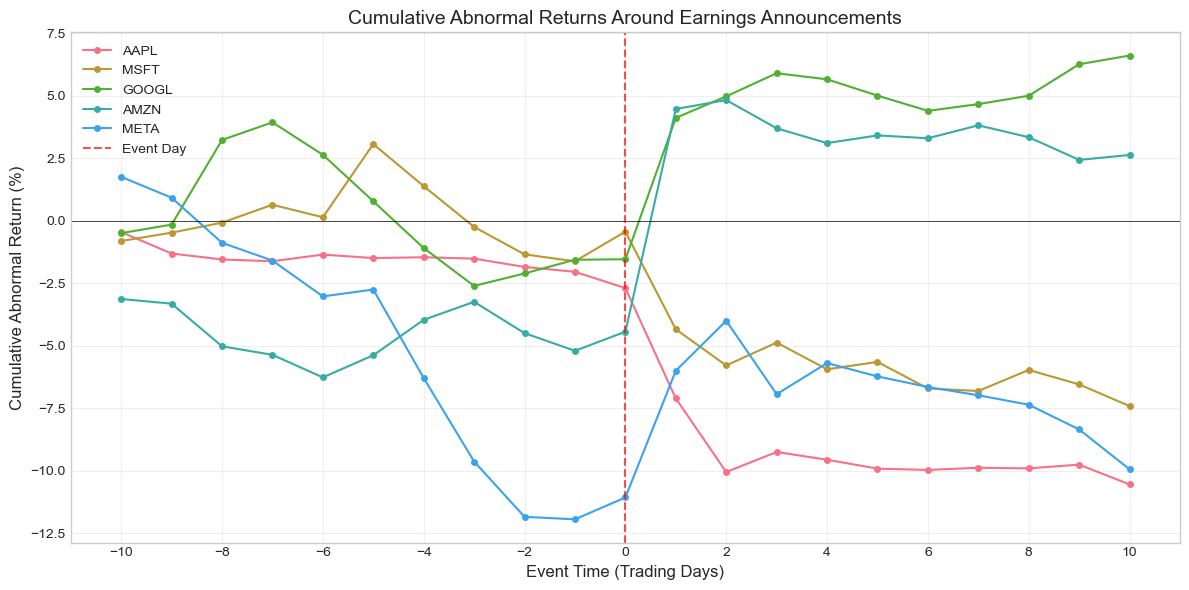

In [14]:
# Plot cumulative ARs over the event window
fig, ax = plt.subplots(figsize=(12, 6))

for result in event_results:
    evt = result['event_data'].sort_values('event_time')
    car = evt['AR'].cumsum()
    ax.plot(evt['event_time'], car * 100, 'o-', label=result['ticker'], 
            markersize=4, linewidth=1.5)

ax.axhline(0, color='black', linewidth=0.5)
ax.axvline(0, color='red', linestyle='--', alpha=0.7, label='Event Day')

ax.set_xlabel('Event Time (Trading Days)', fontsize=12)
ax.set_ylabel('Cumulative Abnormal Return (%)', fontsize=12)
ax.set_title('Cumulative Abnormal Returns Around Earnings Announcements', fontsize=14)
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
ax.set_xticks(range(-EVENT_WINDOW_PRE, EVENT_WINDOW_POST+1, 2))

plt.tight_layout()
plt.show()

## 5. Buy-and-Hold Abnormal Returns (BHAR)

### Definition

BHAR compounds returns rather than summing them:

$$BHAR_i(\tau_1, \tau_2) = \prod_{t=\tau_1}^{\tau_2}(1 + R_{i,t}) - \prod_{t=\tau_1}^{\tau_2}(1 + E[R_{i,t}])$$

Or equivalently:

$$BHAR_i(\tau_1, \tau_2) = \prod_{t=\tau_1}^{\tau_2}(1 + R_{i,t}) - \prod_{t=\tau_1}^{\tau_2}(1 + \hat{\alpha}_i + \hat{\beta}_i R_{m,t})$$

### CAR vs. BHAR

| Aspect | CAR | BHAR |
|--------|-----|------|
| **Calculation** | Sum of ARs | Compound returns |
| **Interpretation** | Average daily abnormal return × days | Actual wealth change |
| **Statistical properties** | Better understood | Right-skewed distribution |
| **Short horizons** | Very similar | Very similar |
| **Long horizons** | May understate compounding | Captures true investor experience |
| **Bias** | Less sensitive to outliers | Sensitive to extreme returns |

In [16]:
def calculate_bhar(event_data: pd.DataFrame, tau1: int, tau2: int) -> float:
    """
    Calculate Buy-and-Hold Abnormal Return.
    
    BHAR = Product(1 + R_actual) - Product(1 + R_expected)
    """
    mask = (event_data['event_time'] >= tau1) & (event_data['event_time'] <= tau2)
    window_data = event_data[mask]
    
    # Compound actual returns
    actual_wealth = np.prod(1 + window_data['stock_ret'].values)
    
    # Compound expected returns
    expected_wealth = np.prod(1 + window_data['expected_ret'].values)
    
    return actual_wealth - expected_wealth


def calculate_bhar_market_adjusted(event_data: pd.DataFrame, tau1: int, tau2: int) -> float:
    """
    Calculate market-adjusted BHAR (simple benchmark).
    
    BHAR = Product(1 + R_stock) - Product(1 + R_market)
    """
    mask = (event_data['event_time'] >= tau1) & (event_data['event_time'] <= tau2)
    window_data = event_data[mask]
    
    stock_wealth = np.prod(1 + window_data['stock_ret'].values)
    market_wealth = np.prod(1 + window_data['market_ret'].values)
    
    return stock_wealth - market_wealth


# Compare CAR and BHAR
print("CAR vs BHAR Comparison:")
print("="*90)

comparison_windows = [(-1, +1), (-5, +5), (-10, +10)]

comparison_data = []
for result in event_results:
    for tau1, tau2 in comparison_windows:
        car = calculate_car(result['event_data'], tau1, tau2)
        bhar = calculate_bhar(result['event_data'], tau1, tau2)
        bhar_ma = calculate_bhar_market_adjusted(result['event_data'], tau1, tau2)
        
        comparison_data.append({
            'Ticker': result['ticker'],
            'Window': f'[{tau1:+d},{tau2:+d}]',
            'CAR': car,
            'BHAR': bhar,
            'BHAR_MA': bhar_ma,
            'Diff (BHAR-CAR)': bhar - car
        })

comp_df = pd.DataFrame(comparison_data)

# Format for display
display_comp = comp_df.copy()
for col in ['CAR', 'BHAR', 'BHAR_MA', 'Diff (BHAR-CAR)']:
    display_comp[col] = display_comp[col].apply(lambda x: f"{x*100:+.3f}%")

print(display_comp.to_string(index=False))

CAR vs BHAR Comparison:
Ticker    Window      CAR     BHAR  BHAR_MA Diff (BHAR-CAR)
  AAPL   [-1,+1]  -5.256%  -5.143%  -4.806%         +0.114%
  AAPL   [-5,+5]  -8.562%  -8.315%  -6.355%         +0.246%
  AAPL [-10,+10] -10.547% -10.083%  -6.416%         +0.465%
  MSFT   [-1,+1]  -2.997%  -3.074%  -2.416%         -0.077%
  MSFT   [-5,+5]  -5.785%  -6.031%  -3.909%         -0.246%
  MSFT [-10,+10]  -7.413%  -7.835%  -3.779%         -0.422%
 GOOGL   [-1,+1]  +6.223%  +6.330%  +7.037%         +0.107%
 GOOGL   [-5,+5]  +2.368%  +2.247%  +4.343%         -0.121%
 GOOGL [-10,+10]  +6.607%  +6.841% +10.801%         +0.234%
  AMZN   [-1,+1]  +8.965%  +8.758%  +8.140%         -0.207%
  AMZN   [-5,+5]  +9.680%  +9.570% +10.267%         -0.110%
  AMZN [-10,+10]  +2.629%  +2.067%  +3.259%         -0.563%
  META   [-1,+1]  +5.842%  +5.965%  +7.271%         +0.124%
  META   [-5,+5]  -3.200%  -3.621%  +1.637%         -0.420%
  META [-10,+10]  -9.942% -11.126%  +1.679%         -1.184%


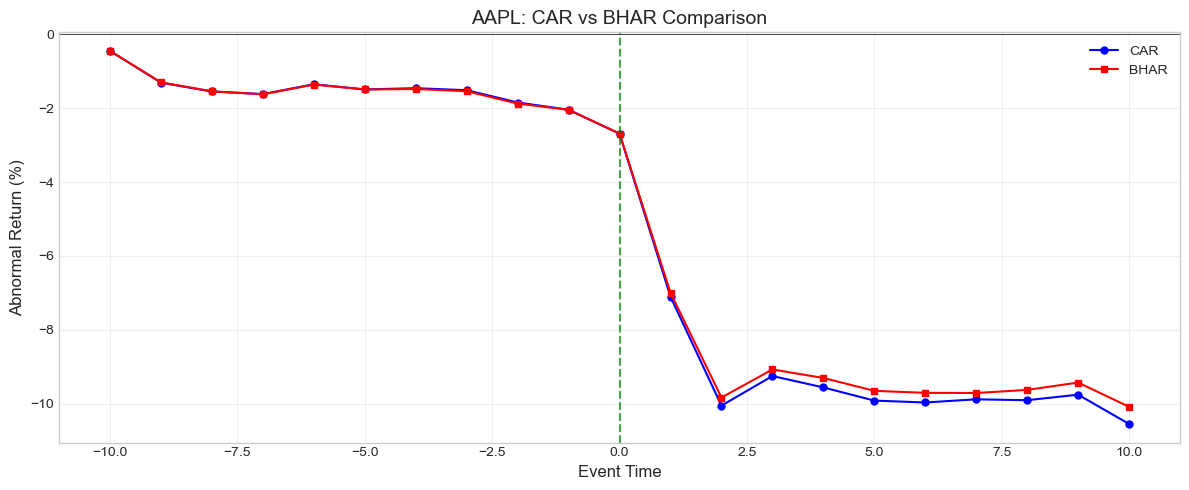


For short windows, CAR and BHAR are nearly identical.
Difference at day +10: 0.4646%


In [18]:
# Visualize CAR vs BHAR over time for one event
example = event_results[0]
evt = example['event_data'].sort_values('event_time')

# Calculate running CAR and BHAR
car_series = evt['AR'].cumsum()

bhar_series = []
start_time = evt['event_time'].min()
for t in evt['event_time']:
    bhar = calculate_bhar(evt, start_time, t)
    bhar_series.append(bhar)

fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(evt['event_time'], car_series * 100, 'b-o', label='CAR', markersize=5)
ax.plot(evt['event_time'], np.array(bhar_series) * 100, 'r-s', label='BHAR', markersize=5)

ax.axhline(0, color='black', linewidth=0.5)
ax.axvline(0, color='green', linestyle='--', alpha=0.7)

ax.set_xlabel('Event Time', fontsize=12)
ax.set_ylabel('Abnormal Return (%)', fontsize=12)
ax.set_title(f'{example["ticker"]}: CAR vs BHAR Comparison', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFor short windows, CAR and BHAR are nearly identical.")
print(f"Difference at day +{EVENT_WINDOW_POST}: {(bhar_series[-1] - car_series.iloc[-1])*100:.4f}%")

## 6. Standardized Abnormal Returns (SAR)

### Motivation

Raw abnormal returns have different variances across firms. Standardization improves cross-sectional comparability and statistical power.

### Definition

$$SAR_{i,t} = \frac{AR_{i,t}}{\hat{\sigma}_{AR_{i,t}}}$$

Where:
$$\hat{\sigma}_{AR_{i,t}} = \sigma_{\epsilon_i} \sqrt{1 + \frac{1}{T} + \frac{(R_{m,t} - \bar{R}_m)^2}{\sum(R_{m,t} - \bar{R}_m)^2}}$$

### Standardized CAR (SCAR)

$$SCAR_i(\tau_1, \tau_2) = \frac{CAR_i(\tau_1, \tau_2)}{\hat{\sigma}_{CAR_i}}$$

Where:
$$\hat{\sigma}_{CAR_i} = \sqrt{\sum_{t=\tau_1}^{\tau_2} \hat{\sigma}^2_{AR_{i,t}}}$$

Under the null: $SAR_{i,t} \sim t(T-2)$ approximately $\sim N(0,1)$ for large T.

In [21]:
def calculate_standardized_ar(event_data: pd.DataFrame, model: Dict) -> pd.Series:
    """
    Calculate Standardized Abnormal Returns (SAR).
    
    SAR = AR / sigma_AR
    """
    ar_var = calculate_ar_variance(model, event_data['market_ret'].values)
    ar_se = np.sqrt(ar_var)
    
    sar = event_data['AR'].values / ar_se
    return pd.Series(sar, index=event_data.index)


def calculate_standardized_car(event_data: pd.DataFrame, model: Dict,
                                tau1: int, tau2: int) -> Tuple[float, float]:
    """
    Calculate Standardized CAR (SCAR).
    
    Returns: (SCAR, CAR)
    """
    car = calculate_car(event_data, tau1, tau2)
    car_var = calculate_car_variance(model, event_data, tau1, tau2)
    car_se = np.sqrt(car_var)
    
    scar = car / car_se if car_se > 0 else 0
    return scar, car


# Calculate SARs for all events
print("Standardized Abnormal Returns (SAR):")
print("="*90)

for result in event_results:
    evt = result['event_data'].copy()
    evt['SAR'] = calculate_standardized_ar(evt, result['model'])
    
    # Display around event day
    display_data = evt[(evt['event_time'] >= -3) & (evt['event_time'] <= 3)]
    
    print(f"\n{result['ticker']}:")
    disp = display_data[['event_time', 'AR', 'SAR']].copy()
    disp['AR'] = disp['AR'].apply(lambda x: f"{x*100:+.2f}%")
    disp['SAR'] = disp['SAR'].apply(lambda x: f"{x:+.3f}")
    print(disp.to_string(index=False))

Standardized Abnormal Returns (SAR):

AAPL:
 event_time     AR    SAR
         -3 -0.05% -0.067
         -2 -0.33% -0.412
         -1 -0.20% -0.239
          0 -0.65% -0.806
          1 -4.41% -5.456
          2 -2.95% -3.642
          3 +0.80% +0.992

MSFT:
 event_time     AR    SAR
         -3 -1.63% -1.158
         -2 -1.10% -0.781
         -1 -0.28% -0.197
          0 +1.19% +0.845
          1 -3.91% -2.782
          2 -1.45% -1.028
          3 +0.92% +0.650

GOOGL:
 event_time     AR    SAR
         -3 -1.51% -0.906
         -2 +0.50% +0.299
         -1 +0.55% +0.328
          0 +0.02% +0.012
          1 +5.65% +3.393
          2 +0.86% +0.514
          3 +0.93% +0.554

AMZN:
 event_time     AR    SAR
         -3 +0.72% +0.409
         -2 -1.25% -0.710
         -1 -0.71% -0.397
          0 +0.76% +0.434
          1 +8.91% +5.045
          2 +0.36% +0.202
          3 -1.13% -0.641

META:
 event_time     AR    SAR
         -3 -3.34% -1.299
         -2 -2.21% -0.860
         -1 -0.10

In [23]:
# Compare SCARs across events
print("\nStandardized CAR (SCAR) Comparison:")
print("="*80)

scar_data = []
for result in event_results:
    for tau1, tau2 in [(-1, +1), (0, 0), (-5, +5)]:
        scar, car = calculate_standardized_car(result['event_data'], result['model'], tau1, tau2)
        
        scar_data.append({
            'Ticker': result['ticker'],
            'Window': f'[{tau1:+d},{tau2:+d}]',
            'CAR': car,
            'SCAR': scar,
            'Significant': '***' if abs(scar) > 2.576 else '**' if abs(scar) > 1.96 else '*' if abs(scar) > 1.645 else ''
        })

scar_df = pd.DataFrame(scar_data)
display_scar = scar_df.copy()
display_scar['CAR'] = display_scar['CAR'].apply(lambda x: f"{x*100:+.2f}%")
display_scar['SCAR'] = display_scar['SCAR'].apply(lambda x: f"{x:+.3f}")

print(display_scar.to_string(index=False))
print("\nSignificance: * p<0.10, ** p<0.05, *** p<0.01")


Standardized CAR (SCAR) Comparison:
Ticker  Window    CAR   SCAR Significant
  AAPL [-1,+1] -5.26% -3.744         ***
  AAPL [+0,+0] -0.65% -0.806            
  AAPL [-5,+5] -8.56% -3.192         ***
  MSFT [-1,+1] -3.00% -1.232            
  MSFT [+0,+0] +1.19% +0.845            
  MSFT [-5,+5] -5.78% -1.241            
 GOOGL [-1,+1] +6.22% +2.155          **
 GOOGL [+0,+0] +0.02% +0.012            
 GOOGL [-5,+5] +2.37% +0.428            
  AMZN [-1,+1] +8.96% +2.924         ***
  AMZN [+0,+0] +0.76% +0.434            
  AMZN [-5,+5] +9.68% +1.652           *
  META [-1,+1] +5.84% +1.310            
  META [+0,+0] +0.87% +0.340            
  META [-5,+5] -3.20% -0.375            

Significance: * p<0.10, ** p<0.05, *** p<0.01


## 7. Aggregating Across Events

### Average Abnormal Return (AAR)

For a sample of $N$ events:

$$AAR_t = \frac{1}{N} \sum_{i=1}^{N} AR_{i,t}$$

### Cumulative Average Abnormal Return (CAAR)

$$CAAR(\tau_1, \tau_2) = \sum_{t=\tau_1}^{\tau_2} AAR_t = \frac{1}{N} \sum_{i=1}^{N} CAR_i(\tau_1, \tau_2)$$

### Variance of CAAR

Assuming independence across firms (no event clustering):

$$Var(CAAR) = \frac{1}{N^2} \sum_{i=1}^{N} Var(CAR_i)$$

In [26]:
def calculate_aar_series(event_results: List[Dict]) -> pd.DataFrame:
    """
    Calculate Average Abnormal Return for each event time.
    """
    # Collect all ARs by event time
    ar_by_time = {}
    
    for result in event_results:
        evt = result['event_data']
        for _, row in evt.iterrows():
            t = int(row['event_time'])
            if t not in ar_by_time:
                ar_by_time[t] = []
            ar_by_time[t].append(row['AR'])
    
    # Calculate statistics
    aar_data = []
    for t in sorted(ar_by_time.keys()):
        ars = np.array(ar_by_time[t])
        n = len(ars)
        aar = np.mean(ars)
        std = np.std(ars, ddof=1) if n > 1 else 0
        se = std / np.sqrt(n) if n > 0 else 0
        t_stat = aar / se if se > 0 else 0
        
        aar_data.append({
            'event_time': t,
            'N': n,
            'AAR': aar,
            'Std': std,
            'SE': se,
            't-stat': t_stat
        })
    
    return pd.DataFrame(aar_data)


def calculate_caar(event_results: List[Dict], tau1: int, tau2: int) -> Dict:
    """
    Calculate Cumulative Average Abnormal Return and test statistics.
    """
    cars = []
    car_vars = []
    
    for result in event_results:
        car = calculate_car(result['event_data'], tau1, tau2)
        car_var = calculate_car_variance(result['model'], result['event_data'], tau1, tau2)
        cars.append(car)
        car_vars.append(car_var)
    
    cars = np.array(cars)
    car_vars = np.array(car_vars)
    N = len(cars)
    
    caar = np.mean(cars)
    
    # Cross-sectional standard error
    cs_se = np.std(cars, ddof=1) / np.sqrt(N)
    
    # Time-series standard error (assuming independence)
    ts_var = np.sum(car_vars) / (N**2)
    ts_se = np.sqrt(ts_var)
    
    return {
        'CAAR': caar,
        'N': N,
        'CS_SE': cs_se,
        'TS_SE': ts_se,
        't_stat_CS': caar / cs_se if cs_se > 0 else 0,
        't_stat_TS': caar / ts_se if ts_se > 0 else 0,
        'individual_CARs': cars
    }


# Calculate AAR series
aar_df = calculate_aar_series(event_results)

print("Average Abnormal Returns (AAR) by Event Time:")
print("="*70)

display_aar = aar_df.copy()
display_aar['AAR'] = display_aar['AAR'].apply(lambda x: f"{x*100:+.3f}%")
display_aar['SE'] = display_aar['SE'].apply(lambda x: f"{x*100:.3f}%")
display_aar['t-stat'] = display_aar['t-stat'].apply(lambda x: f"{x:+.3f}")

print(display_aar.to_string(index=False))

Average Abnormal Returns (AAR) by Event Time:
 event_time  N     AAR      Std     SE t-stat
        -10  5 -0.628% 0.017335 0.775% -0.810
         -9  5 -0.240% 0.005934 0.265% -0.906
         -8  5 +0.007% 0.021109 0.944% +0.008
         -7  5 +0.061% 0.006370 0.285% +0.213
         -6  5 -0.774% 0.006864 0.307% -2.523
         -5  5 +0.419% 0.017342 0.776% +0.540
         -4  5 -1.129% 0.019040 0.852% -1.326
         -3  5 -1.164% 0.015696 0.702% -1.658
         -2  5 -0.879% 0.010196 0.456% -1.927
         -1  5 -0.146% 0.004520 0.202% -0.723
          0  5 +0.439% 0.007444 0.333% +1.319
          1  5 +2.262% 0.060438 2.703% +0.837
          2  5 -0.235% 0.019606 0.877% -0.268
          3  5 -0.285% 0.017214 0.770% -0.370
          4  5 -0.194% 0.008681 0.388% -0.499
          5  5 -0.188% 0.004589 0.205% -0.914
          6  5 -0.452% 0.004102 0.183% -2.464
          7  5 +0.088% 0.003273 0.146% +0.601
          8  5 +0.060% 0.005417 0.242% +0.248
          9  5 -0.214% 0.009375 0.

In [28]:
# Calculate CAAR for standard windows
print("\nCumulative Average Abnormal Returns (CAAR):")
print("="*80)

caar_results = []
for tau1, tau2 in standard_windows:
    result = calculate_caar(event_results, tau1, tau2)
    caar_results.append({
        'Window': f'[{tau1:+d}, {tau2:+d}]',
        'N': result['N'],
        'CAAR': result['CAAR'],
        'CS_SE': result['CS_SE'],
        't-stat (CS)': result['t_stat_CS'],
        't-stat (TS)': result['t_stat_TS']
    })

caar_df = pd.DataFrame(caar_results)

display_caar = caar_df.copy()
display_caar['CAAR'] = display_caar['CAAR'].apply(lambda x: f"{x*100:+.3f}%")
display_caar['CS_SE'] = display_caar['CS_SE'].apply(lambda x: f"{x*100:.3f}%")
display_caar['t-stat (CS)'] = display_caar['t-stat (CS)'].apply(lambda x: f"{x:+.3f}")
display_caar['t-stat (TS)'] = display_caar['t-stat (TS)'].apply(lambda x: f"{x:+.3f}")

print(display_caar.to_string(index=False))
print("\nCS = Cross-sectional, TS = Time-series standard errors")


Cumulative Average Abnormal Returns (CAAR):
    Window  N    CAAR  CS_SE t-stat (CS) t-stat (TS)
 [-10, -2]  5 -4.328% 1.955%      -2.214      -1.853
  [-1, +1]  5 +2.555% 2.803%      +0.912      +1.894
  [+0, +0]  5 +0.439% 0.333%      +1.319      +0.564
  [-5, +5]  5 -1.100% 3.242%      -0.339      -0.426
 [+2, +10]  5 -1.960% 1.166%      -1.681      -0.838
[-10, +10]  5 -3.733% 3.507%      -1.065      -1.046

CS = Cross-sectional, TS = Time-series standard errors


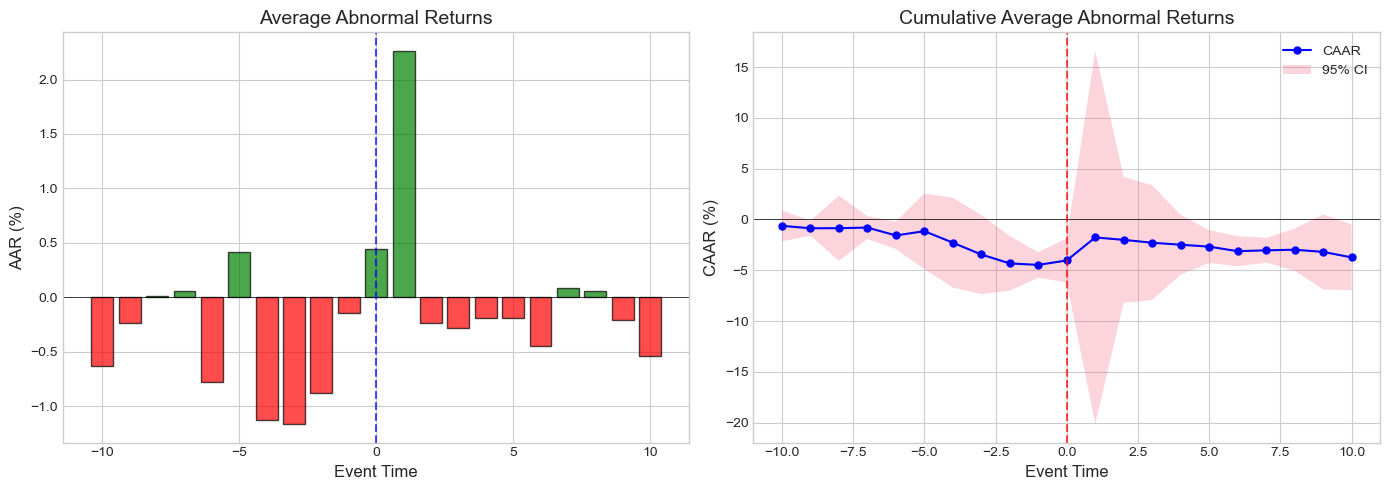

In [30]:
# Plot CAAR with confidence bands
aar_df['CAAR'] = aar_df['AAR'].cumsum()

# Calculate running standard error for CAAR
# Simplified: assume constant variance
aar_df['CAAR_SE'] = aar_df['SE'] * np.sqrt(np.arange(1, len(aar_df) + 1))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# AAR plot
ax1 = axes[0]
colors = ['green' if aar >= 0 else 'red' for aar in aar_df['AAR']]
ax1.bar(aar_df['event_time'], aar_df['AAR']*100, color=colors, alpha=0.7, edgecolor='black')
ax1.axhline(0, color='black', linewidth=0.5)
ax1.axvline(0, color='blue', linestyle='--', alpha=0.7)
ax1.set_xlabel('Event Time', fontsize=12)
ax1.set_ylabel('AAR (%)', fontsize=12)
ax1.set_title('Average Abnormal Returns', fontsize=14)

# CAAR plot with confidence bands
ax2 = axes[1]
ax2.plot(aar_df['event_time'], aar_df['CAAR']*100, 'b-o', markersize=5, label='CAAR')
ax2.fill_between(aar_df['event_time'], 
                  (aar_df['CAAR'] - 1.96*aar_df['CAAR_SE'])*100,
                  (aar_df['CAAR'] + 1.96*aar_df['CAAR_SE'])*100,
                  alpha=0.3, label='95% CI')
ax2.axhline(0, color='black', linewidth=0.5)
ax2.axvline(0, color='red', linestyle='--', alpha=0.7)
ax2.set_xlabel('Event Time', fontsize=12)
ax2.set_ylabel('CAAR (%)', fontsize=12)
ax2.set_title('Cumulative Average Abnormal Returns', fontsize=14)
ax2.legend()

plt.tight_layout()
plt.show()

## 8. Wealth Effects and Economic Significance

### Dollar Wealth Change

The CAR can be translated into dollar terms:

$$\Delta W_i = CAR_i \times MV_{i,t-1}$$

Where $MV_{i,t-1}$ is the market value of equity before the event.

### Aggregate Wealth Effect

$$\Delta W_{total} = \sum_{i=1}^{N} \Delta W_i = \sum_{i=1}^{N} CAR_i \times MV_{i,t-1}$$

### Value-Weighted CAAR

$$CAAR_{VW} = \frac{\sum_{i=1}^{N} CAR_i \times MV_i}{\sum_{i=1}^{N} MV_i}$$

In [33]:
def get_market_cap(ticker: str, date: str) -> float:
    """
    Get approximate market cap for a stock.
    Uses price × shares outstanding.
    """
    try:
        stock = yf.Ticker(ticker)
        info = stock.info
        market_cap = info.get('marketCap', None)
        if market_cap:
            return market_cap
    except:
        pass
    
    # Fallback: use approximate values (in billions)
    approx_caps = {
        'AAPL': 2800e9,
        'MSFT': 2500e9,
        'GOOGL': 1700e9,
        'AMZN': 1400e9,
        'META': 800e9
    }
    return approx_caps.get(ticker, 100e9)


def calculate_wealth_effects(event_results: List[Dict], tau1: int, tau2: int) -> pd.DataFrame:
    """
    Calculate dollar wealth changes from event.
    """
    wealth_data = []
    
    for result in event_results:
        car = calculate_car(result['event_data'], tau1, tau2)
        mkt_cap = get_market_cap(result['ticker'], str(result['event_date']))
        wealth_change = car * mkt_cap
        
        wealth_data.append({
            'Ticker': result['ticker'],
            'Market Cap ($B)': mkt_cap / 1e9,
            f'CAR[{tau1:+d},{tau2:+d}]': car,
            'Wealth Change ($B)': wealth_change / 1e9
        })
    
    df = pd.DataFrame(wealth_data)
    
    # Add totals
    total_mkt_cap = df['Market Cap ($B)'].sum()
    total_wealth_change = df['Wealth Change ($B)'].sum()
    vw_car = total_wealth_change / total_mkt_cap
    
    return df, total_wealth_change, vw_car


# Calculate wealth effects for 3-day window
wealth_df, total_change, vw_car = calculate_wealth_effects(event_results, -1, +1)

print("Wealth Effects Analysis: CAR(-1, +1)")
print("="*70)

display_wealth = wealth_df.copy()
display_wealth['Market Cap ($B)'] = display_wealth['Market Cap ($B)'].apply(lambda x: f"${x:,.0f}")
display_wealth['CAR[-1,+1]'] = display_wealth['CAR[-1,+1]'].apply(lambda x: f"{x*100:+.2f}%")
display_wealth['Wealth Change ($B)'] = display_wealth['Wealth Change ($B)'].apply(lambda x: f"${x:+,.1f}")

print(display_wealth.to_string(index=False))
print(f"\nAggregate Statistics:")
print(f"  Total Wealth Change: ${total_change:+,.1f} billion")
print(f"  Value-Weighted CAAR: {vw_car*100:+.3f}%")
print(f"  Equal-Weighted CAAR: {np.mean(wealth_df['CAR[-1,+1]'])*100:+.3f}%")

Wealth Effects Analysis: CAR(-1, +1)
Ticker Market Cap ($B) CAR[-1,+1] Wealth Change ($B)
  AAPL          $3,670     -5.26%            $-192.9
  MSFT          $3,353     -3.00%            $-100.5
 GOOGL          $4,004     +6.22%            $+249.1
  AMZN          $2,505     +8.96%            $+224.6
  META          $1,632     +5.84%             $+95.4

Aggregate Statistics:
  Total Wealth Change: $+275.7 billion
  Value-Weighted CAAR: +1.818%
  Equal-Weighted CAAR: +2.555%


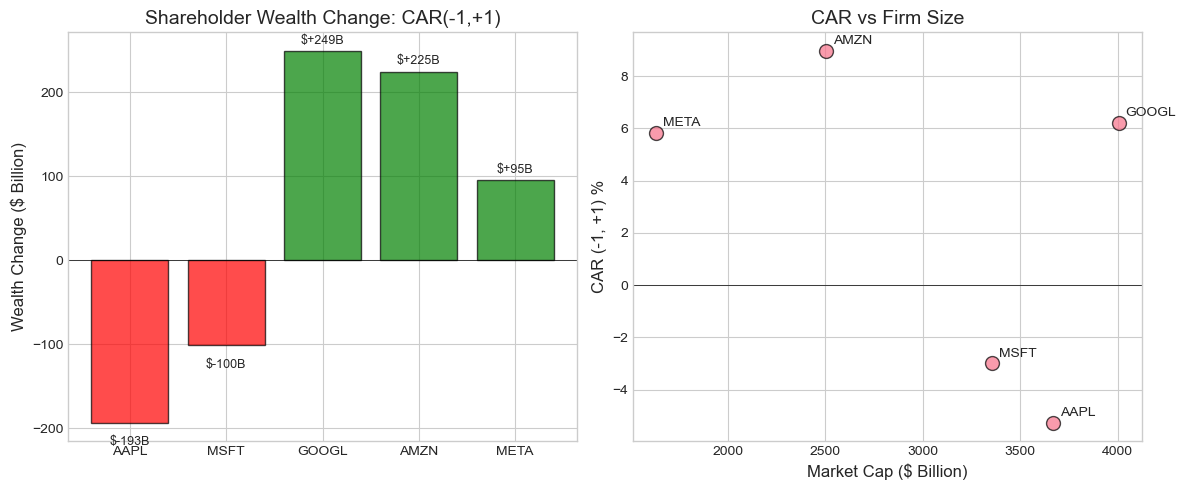

In [35]:
# Visualize wealth effects
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Bar chart of wealth changes
ax1 = axes[0]
colors = ['green' if x >= 0 else 'red' for x in wealth_df['Wealth Change ($B)']]
bars = ax1.bar(wealth_df['Ticker'], wealth_df['Wealth Change ($B)'], color=colors, alpha=0.7, edgecolor='black')
ax1.axhline(0, color='black', linewidth=0.5)
ax1.set_ylabel('Wealth Change ($ Billion)', fontsize=12)
ax1.set_title('Shareholder Wealth Change: CAR(-1,+1)', fontsize=14)

# Add value labels
for bar, val in zip(bars, wealth_df['Wealth Change ($B)']):
    height = bar.get_height()
    ax1.annotate(f'${val:+.0f}B',
                xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3 if height >= 0 else -10),
                textcoords="offset points",
                ha='center', va='bottom' if height >= 0 else 'top',
                fontsize=9)

# Scatter: Market cap vs CAR
ax2 = axes[1]
ax2.scatter(wealth_df['Market Cap ($B)'], wealth_df['CAR[-1,+1]']*100, 
            s=100, alpha=0.7, edgecolors='black')

for i, row in wealth_df.iterrows():
    ax2.annotate(row['Ticker'], 
                (row['Market Cap ($B)'], row['CAR[-1,+1]']*100),
                xytext=(5, 5), textcoords='offset points', fontsize=10)

ax2.axhline(0, color='black', linewidth=0.5)
ax2.set_xlabel('Market Cap ($ Billion)', fontsize=12)
ax2.set_ylabel('CAR (-1, +1) %', fontsize=12)
ax2.set_title('CAR vs Firm Size', fontsize=14)

plt.tight_layout()
plt.show()

## 9. Precision-Weighted Measures

### Motivation

Not all abnormal return estimates are equally precise. Firms with:
- Higher residual variance → less precise AR estimates
- Shorter estimation windows → more estimation error

### Precision-Weighted CAR

Weight each firm's CAR by the inverse of its variance:

$$CAAR_{PW} = \frac{\sum_{i=1}^{N} w_i \cdot CAR_i}{\sum_{i=1}^{N} w_i}$$

Where $w_i = 1/Var(CAR_i)$

In [37]:
def calculate_precision_weighted_caar(event_results: List[Dict], 
                                       tau1: int, tau2: int) -> Dict:
    """
    Calculate precision-weighted CAAR.
    """
    cars = []
    weights = []  # Precision = 1/variance
    
    for result in event_results:
        car = calculate_car(result['event_data'], tau1, tau2)
        car_var = calculate_car_variance(result['model'], result['event_data'], tau1, tau2)
        
        precision = 1 / car_var if car_var > 0 else 0
        
        cars.append(car)
        weights.append(precision)
    
    cars = np.array(cars)
    weights = np.array(weights)
    
    # Normalize weights
    weights_norm = weights / np.sum(weights)
    
    # Precision-weighted CAAR
    pw_caar = np.sum(weights_norm * cars)
    
    # Standard error
    pw_var = 1 / np.sum(weights)
    pw_se = np.sqrt(pw_var)
    
    return {
        'PW_CAAR': pw_caar,
        'PW_SE': pw_se,
        'PW_t_stat': pw_caar / pw_se if pw_se > 0 else 0,
        'EW_CAAR': np.mean(cars),  # Equal-weighted for comparison
        'weights': weights_norm
    }


# Compare equal-weighted and precision-weighted CAAR
print("Equal-Weighted vs Precision-Weighted CAAR:")
print("="*70)

for tau1, tau2 in [(-1, +1), (0, 0), (-5, +5)]:
    pw_result = calculate_precision_weighted_caar(event_results, tau1, tau2)
    
    print(f"\nWindow [{tau1:+d}, {tau2:+d}]:")
    print(f"  Equal-Weighted CAAR:     {pw_result['EW_CAAR']*100:+.3f}%")
    print(f"  Precision-Weighted CAAR: {pw_result['PW_CAAR']*100:+.3f}%")
    print(f"  PW t-statistic:          {pw_result['PW_t_stat']:+.3f}")

Equal-Weighted vs Precision-Weighted CAAR:

Window [-1, +1]:
  Equal-Weighted CAAR:     +2.555%
  Precision-Weighted CAAR: -1.238%
  PW t-statistic:          -1.208

Window [+0, +0]:
  Equal-Weighted CAAR:     +0.439%
  Precision-Weighted CAAR: -0.004%
  PW t-statistic:          -0.007

Window [-5, +5]:
  Equal-Weighted CAAR:     -1.100%
  Precision-Weighted CAAR: -4.379%
  PW t-statistic:          -2.235


## 10. Handling Event Clustering

### The Problem

When events cluster in calendar time (e.g., earnings season), the independence assumption is violated. Cross-sectional correlation inflates test statistics.

### Solutions

1. **Portfolio approach**: Form portfolios of stocks with events on the same day
2. **Crude dependence adjustment**: Reduce degrees of freedom
3. **Calendar-time portfolio**: Regress portfolio returns on factors
4. **Clustered standard errors**: Allow for within-period correlation

In [39]:
def check_event_clustering(event_results: List[Dict]) -> pd.DataFrame:
    """
    Check for event clustering in calendar time.
    """
    dates = [result['event_date'] for result in event_results]
    tickers = [result['ticker'] for result in event_results]
    
    df = pd.DataFrame({'Ticker': tickers, 'Event_Date': dates})
    
    # Count events per date
    cluster_count = df.groupby('Event_Date').size().reset_index(name='N_Events')
    
    return df.merge(cluster_count, on='Event_Date')


def crude_dependence_adjustment(event_results: List[Dict], tau1: int, tau2: int) -> Dict:
    """
    Crude dependence adjustment for clustered events.
    Reduces effective N based on clustering.
    """
    cluster_df = check_event_clustering(event_results)
    
    # Effective N = number of unique event dates
    n_effective = cluster_df['Event_Date'].nunique()
    n_actual = len(event_results)
    
    # Calculate CAAR
    caar_result = calculate_caar(event_results, tau1, tau2)
    
    # Adjust standard error
    adjustment_factor = np.sqrt(n_actual / n_effective)
    adjusted_se = caar_result['CS_SE'] * adjustment_factor
    adjusted_t = caar_result['CAAR'] / adjusted_se if adjusted_se > 0 else 0
    
    return {
        'N_actual': n_actual,
        'N_effective': n_effective,
        'CAAR': caar_result['CAAR'],
        'SE_unadjusted': caar_result['CS_SE'],
        'SE_adjusted': adjusted_se,
        't_unadjusted': caar_result['t_stat_CS'],
        't_adjusted': adjusted_t
    }


# Check clustering
cluster_df = check_event_clustering(event_results)
print("Event Clustering Analysis:")
print("="*50)
print(cluster_df.to_string(index=False))

print(f"\nUnique event dates: {cluster_df['Event_Date'].nunique()}")
print(f"Total events: {len(event_results)}")

# Apply crude dependence adjustment
print("\nCrude Dependence Adjustment (CAR[-1,+1]):")
adj = crude_dependence_adjustment(event_results, -1, +1)
print(f"  Unadjusted t-stat: {adj['t_unadjusted']:+.3f}")
print(f"  Adjusted t-stat:   {adj['t_adjusted']:+.3f}")

Event Clustering Analysis:
Ticker Event_Date  N_Events
  AAPL 2023-08-03         2
  MSFT 2023-07-25         2
 GOOGL 2023-07-25         2
  AMZN 2023-08-03         2
  META 2023-07-26         1

Unique event dates: 3
Total events: 5

Crude Dependence Adjustment (CAR[-1,+1]):
  Unadjusted t-stat: +0.912
  Adjusted t-stat:   +0.706


## 11. Summary Statistics Table

A complete event study report should include summary statistics.

In [41]:
def create_summary_table(event_results: List[Dict], windows: List[Tuple[int, int]]) -> pd.DataFrame:
    """
    Create a comprehensive summary table for event study results.
    """
    summary = []
    
    for tau1, tau2 in windows:
        cars = []
        for result in event_results:
            car = calculate_car(result['event_data'], tau1, tau2)
            cars.append(car)
        
        cars = np.array(cars)
        n = len(cars)
        
        # Calculate statistics
        mean_car = np.mean(cars)
        median_car = np.median(cars)
        std_car = np.std(cars, ddof=1)
        se = std_car / np.sqrt(n)
        t_stat = mean_car / se if se > 0 else 0
        
        # Count positive
        n_positive = np.sum(cars > 0)
        pct_positive = n_positive / n * 100
        
        # Sign test
        sign_stat = (n_positive - n/2) / np.sqrt(n/4)
        
        summary.append({
            'Window': f'[{tau1:+d},{tau2:+d}]',
            'N': n,
            'Mean CAR': mean_car,
            'Median CAR': median_car,
            'Std Dev': std_car,
            't-stat': t_stat,
            '% Positive': pct_positive,
            'Sign Stat': sign_stat
        })
    
    return pd.DataFrame(summary)


# Create summary table
summary_table = create_summary_table(event_results, standard_windows)

print("\n" + "="*90)
print("EVENT STUDY SUMMARY STATISTICS")
print("="*90)
print(f"Sample: {len(event_results)} Big Tech Earnings Announcements (Q2-Q3 2023)")
print(f"Estimation Window: {ESTIMATION_WINDOW} days")
print(f"Model: Market Model (S&P 500 benchmark)")
print("="*90)

display_summary = summary_table.copy()
display_summary['Mean CAR'] = display_summary['Mean CAR'].apply(lambda x: f"{x*100:+.3f}%")
display_summary['Median CAR'] = display_summary['Median CAR'].apply(lambda x: f"{x*100:+.3f}%")
display_summary['Std Dev'] = display_summary['Std Dev'].apply(lambda x: f"{x*100:.3f}%")
display_summary['t-stat'] = display_summary['t-stat'].apply(lambda x: f"{x:+.3f}")
display_summary['% Positive'] = display_summary['% Positive'].apply(lambda x: f"{x:.0f}%")
display_summary['Sign Stat'] = display_summary['Sign Stat'].apply(lambda x: f"{x:+.3f}")

print(display_summary.to_string(index=False))
print("\nSignificance: |t| > 1.645 (10%), |t| > 1.96 (5%), |t| > 2.576 (1%)")


EVENT STUDY SUMMARY STATISTICS
Sample: 5 Big Tech Earnings Announcements (Q2-Q3 2023)
Estimation Window: 120 days
Model: Market Model (S&P 500 benchmark)
   Window  N Mean CAR Median CAR Std Dev t-stat % Positive Sign Stat
 [-10,-2]  5  -4.328%    -2.109%  4.372% -2.214         0%    -2.236
  [-1,+1]  5  +2.555%    +5.842%  6.269% +0.912        60%    +0.447
  [+0,+0]  5  +0.439%    +0.765%  0.744% +1.319        80%    +1.342
  [-5,+5]  5  -1.100%    -3.200%  7.250% -0.339        40%    -0.447
 [+2,+10]  5  -1.960%    -3.070%  2.608% -1.681        20%    -1.342
[-10,+10]  5  -3.733%    -7.413%  7.841% -1.065        40%    -0.447

Significance: |t| > 1.645 (10%), |t| > 1.96 (5%), |t| > 2.576 (1%)


## 12. Exercises

### Exercise 1: Alternative Benchmarks
Recalculate abnormal returns using:
- Market-adjusted returns (beta = 1)
- Industry-adjusted returns (use sector ETF)

### Exercise 2: Long-Horizon BHAR
Extend the event window to [-20, +20] days. Calculate both CAR and BHAR. How much do they diverge?

### Exercise 3: Subsample Analysis
Split the sample by some characteristic (e.g., positive vs negative earnings surprise if you can identify it). Do the subsamples show different patterns?

### Exercise 4: Bootstrap Confidence Intervals
Implement bootstrap confidence intervals for CAAR instead of assuming normality.

In [44]:
# Exercise 4 Template: Bootstrap CAAR

def bootstrap_caar(event_results: List[Dict], tau1: int, tau2: int, 
                   n_bootstrap: int = 1000) -> Dict:
    """
    Bootstrap confidence intervals for CAAR.
    """
    # Calculate individual CARs
    cars = np.array([calculate_car(r['event_data'], tau1, tau2) for r in event_results])
    n = len(cars)
    
    # Original CAAR
    original_caar = np.mean(cars)
    
    # Bootstrap
    bootstrap_caars = []
    for _ in range(n_bootstrap):
        # Resample with replacement
        sample_idx = np.random.choice(n, size=n, replace=True)
        sample_cars = cars[sample_idx]
        bootstrap_caars.append(np.mean(sample_cars))
    
    bootstrap_caars = np.array(bootstrap_caars)
    
    # Confidence intervals
    ci_90 = np.percentile(bootstrap_caars, [5, 95])
    ci_95 = np.percentile(bootstrap_caars, [2.5, 97.5])
    ci_99 = np.percentile(bootstrap_caars, [0.5, 99.5])
    
    return {
        'CAAR': original_caar,
        'Bootstrap_SE': np.std(bootstrap_caars),
        'CI_90': ci_90,
        'CI_95': ci_95,
        'CI_99': ci_99
    }


# Run bootstrap
print("Bootstrap Confidence Intervals for CAAR(-1, +1):")
print("="*50)

boot_result = bootstrap_caar(event_results, -1, +1, n_bootstrap=5000)

print(f"CAAR: {boot_result['CAAR']*100:+.3f}%")
print(f"Bootstrap SE: {boot_result['Bootstrap_SE']*100:.3f}%")
print(f"90% CI: [{boot_result['CI_90'][0]*100:+.3f}%, {boot_result['CI_90'][1]*100:+.3f}%]")
print(f"95% CI: [{boot_result['CI_95'][0]*100:+.3f}%, {boot_result['CI_95'][1]*100:+.3f}%]")
print(f"99% CI: [{boot_result['CI_99'][0]*100:+.3f}%, {boot_result['CI_99'][1]*100:+.3f}%]")

Bootstrap Confidence Intervals for CAAR(-1, +1):
CAAR: +2.555%
Bootstrap SE: 2.522%
90% CI: [-1.960%, +6.695%]
95% CI: [-2.508%, +7.244%]
99% CI: [-3.901%, +7.868%]


## 13. Summary

In this session, we covered:

1. **Daily Abnormal Returns (AR)**: The building block of event studies

2. **Cumulative Abnormal Returns (CAR)**: Summing ARs over event windows

3. **Buy-and-Hold Abnormal Returns (BHAR)**: Compounding for true wealth effects

4. **Standardized Abnormal Returns (SAR/SCAR)**: Improving cross-sectional comparability

5. **Aggregation Methods**:
   - Average Abnormal Return (AAR)
   - Cumulative Average Abnormal Return (CAAR)
   - Precision-weighted aggregation

6. **Economic Interpretation**:
   - Dollar wealth changes
   - Value-weighted vs. equal-weighted measures

7. **Event Clustering**: The problem and solutions

### Key Takeaways

- CAR and BHAR are nearly identical for short windows
- Standardization improves statistical power
- Always report multiple windows for robustness
- Consider economic significance, not just statistical significance
- Watch out for event clustering

### Coming Up Next

**Session 4: Statistical Inference I - Parametric Tests** will cover:
- The Patell test
- Boehmer-Musumeci-Poulsen (BMP) test
- Cross-sectional vs. time-series variance
- Event-induced variance

## 14. References

### Methodology
- Fama, E. F. (1998). Market efficiency, long-term returns, and behavioral finance. *Journal of Financial Economics*, 49(3), 283-306.
- Barber, B. M., & Lyon, J. D. (1997). Detecting long-run abnormal stock returns: The empirical power and specification of test statistics. *Journal of Financial Economics*, 43(3), 341-372.
- Lyon, J. D., Barber, B. M., & Tsai, C. L. (1999). Improved methods for tests of long-run abnormal stock returns. *Journal of Finance*, 54(1), 165-201.

### Applications
- MacKinlay, A. C. (1997). Event studies in economics and finance. *Journal of Economic Literature*, 35(1), 13-39.
- Kothari, S. P., & Warner, J. B. (2007). Econometrics of event studies. *Handbook of Corporate Finance*, 1, 3-36.